<a href="https://colab.research.google.com/github/saahil-jain/Covid_19_predictor/blob/master/CasesDeathsLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import os

Using TensorFlow backend.


In [2]:
print(os.getcwd())
if os.getcwd().split("/")[-1] == "Covid_19_predictor":
  print("Current working directory is already Covid_19_predictor")
elif os.path.isdir("Covid_19_predictor"):
  print("Covid_19_predictor already Exists")
else:
  ! git clone https://github.com/saahil-jain/Covid_19_predictor.git

/content
Cloning into 'Covid_19_predictor'...
remote: Enumerating objects: 50, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 50 (delta 21), reused 6 (delta 1), pack-reused 0
Unpacking objects: 100% (50/50), done.


In [3]:
if os.path.isdir("Covid_19_predictor"):
  % cd Covid_19_predictor
! git pull

/content/Covid_19_predictor
Already up to date.


In [0]:
df = pd.read_csv('data.csv' , usecols = ['countriesAndTerritories'])
ctcset = set()
for i in range(len(df.values)):
  ctcset.add(df.values[i][0])
ctclist = list(ctcset)
ctclist = ["United_States_of_America", "France", "Italy"]

In [0]:
df = pd.read_csv('data.csv' , date_parser=['dateRep'])
dfs = {}
for ctc in ctclist:
  dftemp = pd.read_csv('data.csv' , date_parser=['dateRep'])
  dftemp = dftemp.loc[df['countriesAndTerritories'] == ctc]
  dftemp["dateRep"] = pd.to_datetime(dftemp["dateRep"])
  dftemp = dftemp.sort_values(by="dateRep")
  dfs[ctc] = dftemp

In [0]:
dfs_cases = {}
datasets_cases = {}
dfs_deaths = {}
datasets_deaths = {}
for ctc in ctclist:
  dfs_cases[ctc] = dfs[ctc]['cases']
  datasets_cases[ctc] = dfs_cases[ctc].values
  dfs_deaths[ctc] = dfs[ctc]['deaths']
  datasets_deaths[ctc] = dfs_deaths[ctc].values
  datasets_cases[ctc] = datasets_cases[ctc].astype('float32')
  datasets_deaths[ctc] = datasets_deaths[ctc].astype('float32')

In [0]:
scaler = MinMaxScaler(feature_range=(0, 1))
for ctc in ctclist:
  datasets_cases[ctc] = np.array(datasets_cases[ctc]).reshape(-1 , 1)
  datasets_deaths[ctc] = np.array(datasets_deaths[ctc]).reshape(-1 , 1)
  datasets_cases[ctc] = scaler.fit_transform(datasets_cases[ctc])
  datasets_deaths[ctc] = scaler.fit_transform(datasets_deaths[ctc])

In [0]:
trains_cases = {}
tests_cases = {}
trains_deaths = {}
tests_deaths = {}
for ctc in ctclist:
  train_size_cases = int(len(datasets_cases[ctc]) * 0.67)
  test_size_cases = len(datasets_cases[ctc]) - train_size_cases
  trains_cases[ctc], tests_cases[ctc] = datasets_cases[ctc][0:train_size_cases], datasets_cases[ctc][train_size_cases:len(datasets_cases[ctc])]
  train_size_deaths = int(len(datasets_deaths[ctc]) * 0.67)
  test_size_deaths = len(datasets_deaths[ctc]) - train_size_deaths
  trains_deaths[ctc], tests_deaths[ctc] = datasets_deaths[ctc][0:train_size_deaths], datasets_deaths[ctc][train_size_deaths:len(datasets_deaths[ctc])]

In [0]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back)]
		dataX.append(a)
		dataY.append(dataset[i + look_back])
	return np.array(dataX), np.array(dataY)

In [0]:
look_back = 1
trainXs_cases = {}
trainYs_cases = {}
trainXs_deaths = {}
trainYs_deaths= {}
testXs_cases = {}
testYs_cases = {}
testXs_deaths = {}
testYs_deaths= {}
for ctc in ctclist:
  trainXs_cases[ctc], trainYs_cases[ctc] = create_dataset(trains_cases[ctc], look_back)
  testXs_cases[ctc], testYs_cases[ctc] = create_dataset(tests_cases[ctc], look_back)

  trainXs_deaths[ctc], trainYs_deaths[ctc] = create_dataset(trains_deaths[ctc], look_back)
  testXs_deaths[ctc], testYs_deaths[ctc] = create_dataset(tests_deaths[ctc], look_back)

In [0]:
for ctc in ctclist:
  trainXs_cases[ctc] = np.reshape(trainXs_cases[ctc], (trainXs_cases[ctc].shape[0], 1, trainXs_cases[ctc].shape[1]))
  testXs_cases[ctc] = np.reshape(testXs_cases[ctc], (testXs_cases[ctc].shape[0], 1, testXs_cases[ctc].shape[1]))

  trainXs_deaths[ctc] = np.reshape(trainXs_deaths[ctc], (trainXs_deaths[ctc].shape[0], 1, trainXs_deaths[ctc].shape[1]))
  testXs_deaths[ctc] = np.reshape(testXs_deaths[ctc], (testXs_deaths[ctc].shape[0], 1, testXs_deaths[ctc].shape[1]))

In [12]:
# create and fit the LSTM network
model_cases = Sequential()
model_cases.add(LSTM(4, input_shape=(1, look_back)))
model_cases.add(Dense(1))
model_cases.compile(loss='mean_squared_error', optimizer='adam')
model_cases.fit(trainXs_cases[ctc], trainYs_cases[ctc], epochs=80, batch_size=1, verbose=2)


model_deaths = Sequential()
model_deaths.add(LSTM(2, input_shape=(1, look_back)))
model_deaths.add(Dense(1))
model_deaths.compile(loss='mean_squared_error', optimizer='adam')
for ctc in ctclist:
  model_deaths.fit(trainXs_deaths[ctc], trainYs_deaths[ctc], epochs=53, batch_size=1, verbose=2)

Epoch 1/80
 - 1s - loss: 0.1284
Epoch 2/80
 - 0s - loss: 0.0912
Epoch 3/80
 - 0s - loss: 0.0732
Epoch 4/80
 - 0s - loss: 0.0651
Epoch 5/80
 - 0s - loss: 0.0597
Epoch 6/80
 - 0s - loss: 0.0555
Epoch 7/80
 - 0s - loss: 0.0518
Epoch 8/80
 - 0s - loss: 0.0485
Epoch 9/80
 - 0s - loss: 0.0459
Epoch 10/80
 - 0s - loss: 0.0438
Epoch 11/80
 - 0s - loss: 0.0419
Epoch 12/80
 - 0s - loss: 0.0399
Epoch 13/80
 - 0s - loss: 0.0387
Epoch 14/80
 - 0s - loss: 0.0378
Epoch 15/80
 - 0s - loss: 0.0368
Epoch 16/80
 - 0s - loss: 0.0363
Epoch 17/80
 - 0s - loss: 0.0359
Epoch 18/80
 - 0s - loss: 0.0356
Epoch 19/80
 - 0s - loss: 0.0352
Epoch 20/80
 - 0s - loss: 0.0351
Epoch 21/80
 - 0s - loss: 0.0350
Epoch 22/80
 - 0s - loss: 0.0349
Epoch 23/80
 - 0s - loss: 0.0348
Epoch 24/80
 - 0s - loss: 0.0347
Epoch 25/80
 - 0s - loss: 0.0348
Epoch 26/80
 - 0s - loss: 0.0345
Epoch 27/80
 - 0s - loss: 0.0345
Epoch 28/80
 - 0s - loss: 0.0346
Epoch 29/80
 - 0s - loss: 0.0347
Epoch 30/80
 - 0s - loss: 0.0348
Epoch 31/80
 - 0s -

In [0]:
trainPredicts_cases = {}
testPredicts_cases = {}
trainPredicts_deaths = {}
testPredicts_deaths = {}
trainScores_cases = {}
trainScores_deaths = {}
for ctc in ctclist:
  trainPredicts_cases[ctc] = model_cases.predict(trainXs_cases[ctc])
  testPredicts_cases[ctc] = model_cases.predict(testXs_cases[ctc])

  trainPredicts_cases[ctc] = scaler.inverse_transform(trainPredicts_cases[ctc])
  trainYs_cases[ctc] = scaler.inverse_transform(trainYs_cases[ctc])
  testPredicts_cases[ctc] = scaler.inverse_transform(testPredicts_cases[ctc])
  testYs_cases[ctc] = scaler.inverse_transform(testYs_cases[ctc])

  trainPredicts_deaths[ctc] = model_deaths.predict(trainXs_deaths[ctc])
  testPredicts_deaths[ctc] = model_deaths.predict(testXs_deaths[ctc])

  trainPredicts_deaths[ctc] = scaler.inverse_transform(trainPredicts_deaths[ctc])
  trainYs_deaths[ctc] = scaler.inverse_transform(trainYs_deaths[ctc])
  testPredicts_deaths[ctc] = scaler.inverse_transform(testPredicts_deaths[ctc])
  testYs_deaths[ctc] = scaler.inverse_transform(testYs_deaths[ctc])

United_States_of_America


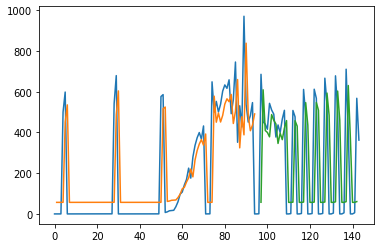

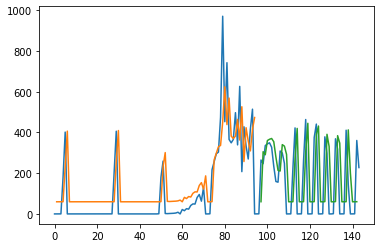

France


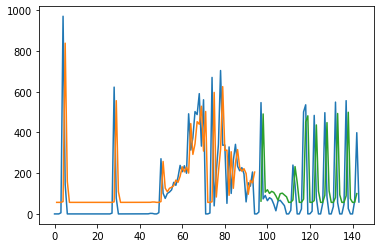

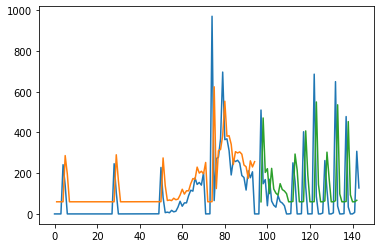

Italy


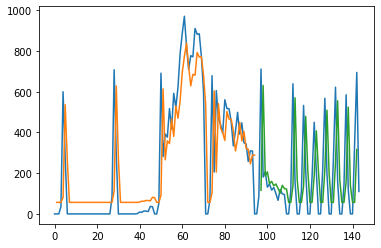

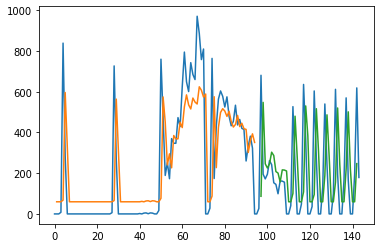

In [15]:
for ctc in ctclist:
  print(ctc)
  # shift train predictions for plotting
  trainPredictPlot_cases = np.empty_like(datasets_cases[ctc])
  trainPredictPlot_cases[:, :] = np.nan
  trainPredictPlot_cases[look_back:len(trainPredicts_cases[ctc])+look_back, :] = trainPredicts_cases[ctc]
  # shift test predictions for plotting
  testPredictPlot_cases = np.empty_like(datasets_cases[ctc])
  testPredictPlot_cases[:, :] = np.nan
  testPredictPlot_cases[len(trainPredicts_cases[ctc])+(look_back*2)+1:len(datasets_cases[ctc])-1, :] = testPredicts_cases[ctc]
  # plot baseline and predictions
  plt.plot(scaler.inverse_transform(datasets_cases[ctc]))
  plt.plot(trainPredictPlot_cases)
  plt.plot(testPredictPlot_cases)
  plt.show()

  # shift train predictions for plotting
  trainPredictPlot_deaths = np.empty_like(datasets_deaths[ctc])
  trainPredictPlot_deaths[:, :] = np.nan
  trainPredictPlot_deaths[look_back:len(trainPredicts_deaths[ctc])+look_back, :] = trainPredicts_deaths[ctc]
  # shift test predictions for plotting
  testPredictPlot_deaths = np.empty_like(datasets_deaths[ctc])
  testPredictPlot_deaths[:, :] = np.nan
  testPredictPlot_deaths[len(trainPredicts_deaths[ctc])+(look_back*2)+1:len(datasets_deaths[ctc])-1, :] = testPredicts_deaths[ctc]
  # plot baseline and predictions
  plt.plot(scaler.inverse_transform(datasets_deaths[ctc]))
  plt.plot(trainPredictPlot_deaths)
  plt.plot(testPredictPlot_deaths)
  plt.show()